In [2]:
import logging

import pandas as pd
import plotly.graph_objects as go
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import DistributionLoss
from ray import tune
from utilsforecast.losses import mae, mse

logging.getLogger("pytorch_lightning").setLevel(logging.INFO)
pd.set_option("display.max_columns", 50)
# torch.set_float32_matmul_precision('high')

## Functions

In [3]:
def plot(df_hat, levels=None, model_name=None):
    """
    Plot historical data and forecasts with optional prediction intervals.

    Parameters:
    -----------
    df_hist : DataFrame
        Historical data with columns 'ds' and 'y'
    df_hat : DataFrame
        Forecast data with columns 'ds', 'unique_id', model predictions, and optional prediction intervals
    levels : list of int, optional
        Confidence levels for prediction intervals (e.g., [80, 90])
    """
    dash_styles = ["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]

    # Extract base model names (without -lo-XX or -hi-XX suffixes)
    models = []
    for col in df_hat.columns:
        if col in ["ds", "unique_id", "cutoff", "y"]:
            continue
        # Check if it's a base model (not a level column)
        if not any(
            col.endswith(f"-lo-{level}") or col.endswith(f"-hi-{level}")
            for level in levels or []
        ):
            models.append(col)

    fig = go.Figure()

    # Add historical data
    fig.add_trace(
        go.Scatter(
            x=df_hat["ds"],
            y=df_hat["y"],
            mode="lines",
            name="Historical",
            line=dict(color="black", width=2),
        )
    )

    # Add forecasts and prediction intervals
    colors = ["blue", "red", "green", "purple", "orange", "brown"]

    for i, model in enumerate(models):
        color = colors[i % len(colors)]

        # Add main forecast line
        fig.add_trace(
            go.Scatter(
                x=df_hat["ds"],
                y=df_hat[model],
                mode="lines",
                name=model,
                line=dict(dash=dash_styles[i % len(dash_styles)], color=color, width=2),
            )
        )
        
        if levels:
            for level in sorted(levels, reverse=True):  # Plot wider intervals first
                lo_col = f"{model}-lo-{level}"
                hi_col = f"{model}-hi-{level}"

                if lo_col in df_hat.columns and hi_col in df_hat.columns:
                    # Add upper bound (invisible line, just for fill)
                    fig.add_trace(
                        go.Scatter(
                            x=df_hat["ds"],
                            y=df_hat[hi_col],
                            mode="lines",
                            line=dict(width=0),
                            showlegend=False,
                            hoverinfo="skip",
                        )
                    )

                    # Add lower bound with fill
                    fig.add_trace(
                        go.Scatter(
                            x=df_hat["ds"],
                            y=df_hat[lo_col],
                            mode="lines",
                            line=dict(width=0),
                            fillcolor=f"rgba({int(color == 'blue') * 0},{int(color == 'red') * 255},{int(color == 'green') * 0},0.{100 - level // 2})",
                            fill="tonexty",
                            name=f"{model} {level}% PI",
                            hoverinfo="skip",
                        )
                    )

    fig.update_layout(
        title="Germany Historical vs Forecast",
        width=1400,
        height=500,
        xaxis_title="Date",
        yaxis_title="Value",
        hovermode="x unified",
    )

    return fig

def plot_test_forecast(df_hat, levels=None):
    """
    Plot historical data and forecasts with optional prediction intervals.

    Parameters:
    -----------
    df_hat : DataFrame
        Forecast data with columns 'ds', 'unique_id', model predictions, and optional prediction intervals
    levels : list of int, optional
        Confidence levels for prediction intervals (e.g., [80, 90])
    """
    dash_styles = ["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]

    # Extract base model names (without -lo-XX or -hi-XX suffixes)
    models = []
    for col in df_hat.columns:
        if col in ["ds", "unique_id", "cutoff", "y"]:
            continue
        # Check if it's a base model (not a level column)
        if not any(
            col.endswith(f"-lo-{level}") or col.endswith(f"-hi-{level}")
            for level in levels or []
        ):
            models.append(col)

    fig = go.Figure()

    # Add historical data
    fig.add_trace(
        go.Scatter(
            x=df_hat["ds"],
            y=df_hat["y"],
            mode="lines",
            name="Historical",
            line=dict(color="black", width=2),
        )
    )

    # Add forecasts and prediction intervals
    colors = ["blue", "red", "green", "purple", "orange", "brown"]

    for i, model in enumerate(models):
        color = colors[i % len(colors)]

        # Add main forecast line
        fig.add_trace(
            go.Scatter(
                x=df_hat["ds"],
                y=df_hat[model],
                mode="lines",
                name=model,
                line=dict(dash=dash_styles[i % len(dash_styles)], color=color, width=2),
            )
        )

        # Add prediction intervals if levels are provided
        if levels:
            for level in sorted(levels, reverse=True):  # Plot wider intervals first
                lo_col = f"{model}-lo-{level}"
                hi_col = f"{model}-hi-{level}"

                if lo_col in df_hat.columns and hi_col in df_hat.columns:
                    # Add upper bound (invisible line, just for fill)
                    fig.add_trace(
                        go.Scatter(
                            x=df_hat["ds"],
                            y=df_hat[hi_col],
                            mode="lines",
                            line=dict(width=0),
                            showlegend=False,
                            hoverinfo="skip",
                        )
                    )

                    # Add lower bound with fill
                    fig.add_trace(
                        go.Scatter(
                            x=df_hat["ds"],
                            y=df_hat[lo_col],
                            mode="lines",
                            line=dict(width=0),
                            fillcolor=f"rgba({int(color == 'blue') * 0},{int(color == 'red') * 255},{int(color == 'green') * 0},0.{100 - level // 2})",
                            fill="tonexty",
                            name=f"{model} {level}% PI",
                            hoverinfo="skip",
                        )
                    )

    fig.update_layout(
        title="Germany Historical vs Forecast",
        width=1400,
        height=500,
        xaxis_title="Date",
        yaxis_title="Value",
        hovermode="x unified",
    )

    return fig


## Load Data

In [4]:
# Y_df = pd.read_csv(
#     "/mnt/data/oe215/rhindrikson/datasets/load/entsoe-hourly/data.csv", parse_dates=["ds"]
# )
# futr_df = pd.read_csv(
#     "/mnt/data/oe215/rhindrikson/datasets/load/entsoe-hourly/futr.csv", parse_dates=["ds"]
# )

Y_df = pd.read_csv(
    "/mnt/data/oe215/rhindrikson/datasets/load/entsoe-15min/example-processed-data/data.csv", parse_dates=["ds"]
)


In [5]:
horizon = int(24/0.25)
# Define validation and test size
n_time = len(Y_df.ds.unique())
val_size = int(0.05 * n_time)
val_size = val_size - (val_size % horizon)
test_size = int(0.05 * n_time)
test_size = test_size - (test_size % horizon)
print(val_size % horizon)
print(test_size % horizon)
print(n_time)
print(val_size)
Y_df.groupby("unique_id").head(2)

0
0
97629
4800


,Unnamed: 0,ds,y,unique_id,temperature,week_day,is_holiday,day_before_holiday,day_after_holiday
0,0,2022-01-01 21:00:00,48091,load,7.069933,5,1,0,0
1,1,2022-01-01 21:15:00,47792,load,7.025423,5,1,0,0


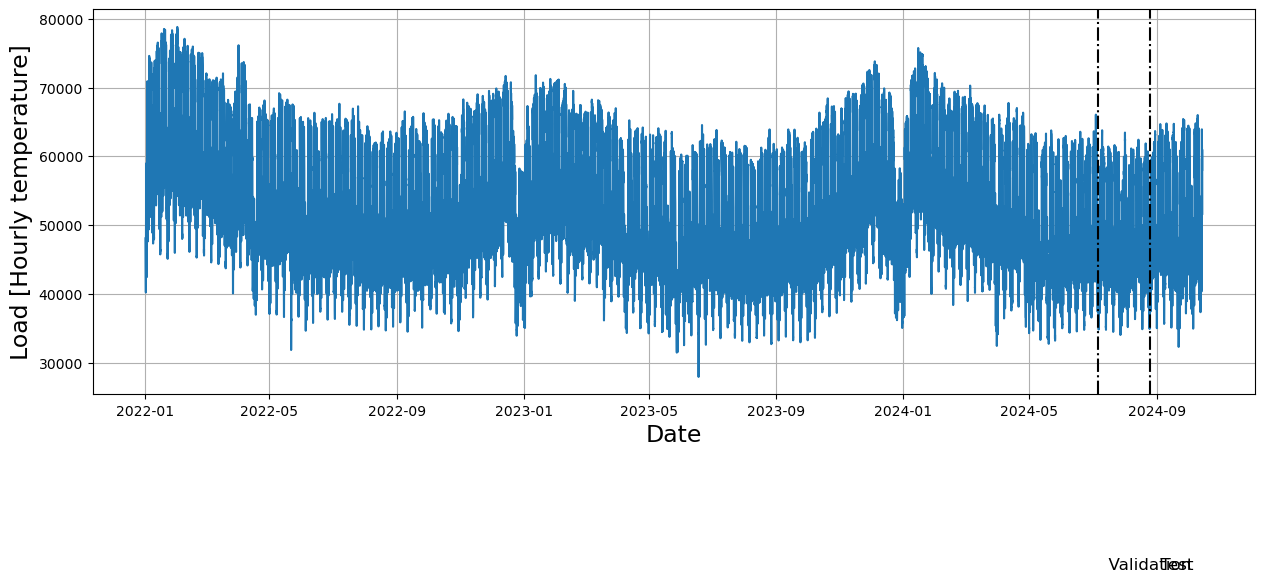

In [6]:
import matplotlib.pyplot as plt

# We are going to plot the temperature of the transformer
# and marking the validation and train splits
u_id = "load"
x_plot = pd.to_datetime(Y_df[Y_df.unique_id == u_id].ds)
y_plot = Y_df[Y_df.unique_id == u_id].y.values

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig = plt.figure(figsize=(15, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel("Date", fontsize=17)
plt.ylabel("Load [Hourly temperature]", fontsize=17)

plt.axvline(x_val, color="black", linestyle="-.")
plt.axvline(x_test, color="black", linestyle="-.")
plt.text(x_val, 5, "  Validation", fontsize=12)
plt.text(x_test, 5, "  Test", fontsize=12)

plt.grid()

## Model

In [7]:
nhits_config = {
    "learning_rate": tune.choice([1e-3]),  # Initial Learning rate
    "max_steps": tune.choice([1000]),  # Number of SGD steps
    "input_size": tune.choice([104 * horizon]),  # input_size = multiplier * horizon
    "batch_size": tune.choice([7]),  # Number of series in windows
    "windows_batch_size": tune.choice([256]),  # Number of windows in batch
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),  # MaxPool's Kernelsize
    "n_freq_downsample": tune.choice(
        [[168, 24, 1], [24, 12, 1], [1, 1, 1]]
    ),  # Interpolation expressivity ratios
    "activation": tune.choice(["ReLU"]),  # Type of non-linear activation
    "n_blocks": tune.choice([[1, 1, 1]]),  # Blocks per each 3 stacks
    "mlp_units": tune.choice(
        [[[512, 512], [512, 512], [512, 512]]]
    ),  # 2 512-Layers per block for each stack
    "interpolation_mode": tune.choice(["linear"]),  # Type of multi-step interpolation
    "val_check_steps": tune.choice([100]),  # Compute validation every 100 epochs
    "random_seed": tune.randint(1, 10),
}

def config_nhits(trial):
    return {
        "input_size": trial.suggest_categorical(          # Length of input window
            "input_size", (horizon, horizon*2, horizon*3, horizon*5, horizon * 365)                
        ),                                                
        "hist_exog_list": ["temperature", "week_day", "is_holiday", "day_before_holiday", "day_after_holiday"],
        "start_padding_enabled": True,                                          
        "n_blocks": 5 * [1],                              # Length of input window
        "mlp_units": 5 * [[64, 64]],                      # Length of input window
        "n_pool_kernel_size": trial.suggest_categorical(  # MaxPooling Kernel size
            "n_pool_kernel_size",
            (5*[1], 5*[2], 5*[4], [8, 4, 2, 1, 1])
        ),     
        "n_freq_downsample": trial.suggest_categorical(   # Interpolation expressivity ratios
            "n_freq_downsample",
            ([8, 4, 2, 1, 1],  [1, 1, 1, 1, 1])
        ),     
        "learning_rate": trial.suggest_float(             # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),            
        "scaler_type": None,                              # Scaler type
        "max_steps": 1000,                                # Max number of training iterations
        "batch_size": trial.suggest_categorical(          # Number of series in batch
            "batch_size",
            (1, 4, 10),
        ),                   
        "windows_batch_size": trial.suggest_categorical(  # Number of windows in batch
            "windows_batch_size",
            (128, 256, 512),
        ),      
        "random_seed": trial.suggest_int(                 # Random seed   
            "random_seed",
            low=1,
            high=20,
        ),                      
    }

In [8]:
print(nhits_config)

{'learning_rate': <ray.tune.search.sample.Categorical object at 0x7f3fab46ff10>, 'max_steps': <ray.tune.search.sample.Categorical object at 0x7f3fab4493d0>, 'input_size': <ray.tune.search.sample.Categorical object at 0x7f3fa8d38d50>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x7f3fab460ad0>, 'windows_batch_size': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5ead0>, 'n_pool_kernel_size': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5eb90>, 'n_freq_downsample': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5ec90>, 'activation': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5ed50>, 'n_blocks': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5ee50>, 'mlp_units': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5f050>, 'interpolation_mode': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5f150>, 'val_check_steps': <ray.tune.search.sample.Categorical object at 0x7f3fa8d5f250>, 'random_seed': <ray.tune.search.sample.I

## Instantiate Model

To instantiate `AutoNHITS` you need to define:

* `h`: forecasting horizon
* `loss`: training loss. Use the `DistributionLoss` to produce probabilistic forecasts.
* `config`: hyperparameter search space. If `None`, the `AutoNHITS` class will use a pre-defined suggested hyperparameter space.
* `num_samples`: number of configurations explored.

If num_samples equals 5, the AutoNHITS model will randomly sample 5 different combinations of hyperparameters from the search space defined in nhits_config.
Each configuration will be trained and evaluated.
The best performing configuration (based on validation performance) will be selected as the final model

For loss, common distribution options include:
- 'Normal' or 'Gaussian' - for normal/gaussian distribution
- 'StudentT' or 'T' - for Student's t-distribution
- 'NegativeBinomial' - for count data
- 'Poisson' - for count data
- 'Tweedie' - for non-negative continuous data



In [9]:
levels = [80, 90]
# loss=MQLoss(level=levels),
loss = DistributionLoss(distribution="Normal", level=levels)
models = [
    AutoNHITS(
        h=horizon,
        loss=loss,
        config=None,
        num_samples=10,
        backend='optuna',
                          )
]

print(models[0])

AutoNHITS


In [25]:
%%capture
nf = NeuralForecast(models=models, freq="15min")

Y_hat_df = nf.cross_validation(
    df=Y_df, val_size=val_size, test_size=test_size, step_size=horizon, n_windows=None, refit=False
    
)

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 3.1 M  | train
----------------------------------------------------------
3.1 M     Trainable params
5         Non-trainable params
3.1 M     Total params
12.382    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Serve

In [26]:
duplicates = Y_hat_df["ds"].duplicated().sum()
print(duplicates)
# print(Y_hat_df.head())
#u = Y_hat_df["cutoff"].unique()
#print(u)
unique_cutoffs = sorted(Y_hat_df["cutoff"].unique())
recent_cutoffs = unique_cutoffs[-5:]
print(recent_cutoffs)

Y_hat_df = Y_hat_df[Y_hat_df["cutoff"].isin(recent_cutoffs)].copy()
print(Y_hat_df.head())
print(len(Y_hat_df))




SyntaxError: invalid syntax (3035342861.py, line 2)

## Evaluate Results

The `AutoNHITS` class contains a `results` tune attribute that stores information of each configuration explored. It contains the validation loss and best validation hyperparameter.

In [51]:
# nf.models[0].results.get_best_result().config
results = nf.models[0].results.trials_dataframe()
best_config = results.iloc[0, :].to_dict()

loss = best_config["value"]
params = best_config["user_attrs_ALL_PARAMS"]

print("Loss", loss)
print("Params", params)
loss

Loss 4.5796041761218514e+23
Params {'h': 96, 'n_pool_kernel_size': [16, 8, 1], 'n_freq_downsample': [180, 60, 1], 'learning_rate': 0.007063201528105938, 'scaler_type': None, 'max_steps': 900.0, 'batch_size': 256, 'windows_batch_size': 128, 'loss': DistributionLoss(), 'random_seed': 1, 'input_size': 384, 'step_size': 96, 'valid_loss': DistributionLoss()}


4.5796041761218514e+23

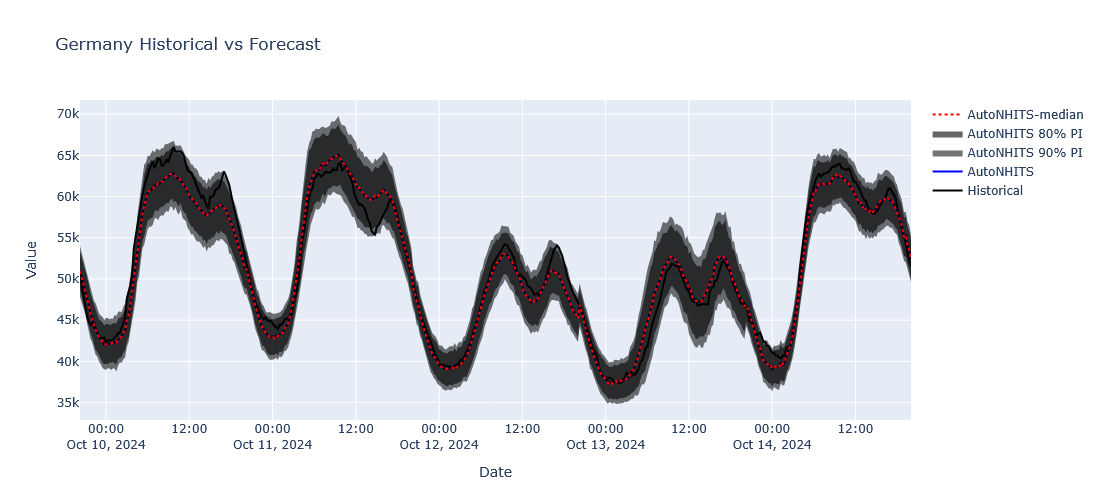

In [23]:
## plot_test_forecast(Y_hat_df)
plot_test_forecast(Y_hat_df, levels=levels)
#fig.write_html("./plot.html")

In [25]:
# Filter Y_df just for the time between the start of the validation and the end of test
selection_start = val_size + test_size

Y_df_start = Y_df['ds'].iloc[-selection_start]
Y_df_filt = Y_df[Y_df['ds'] >= Y_df_start]

Y_hat_start = Y_hat_df['ds'].iloc[-test_size]
Y_hat_filt = Y_hat_df[Y_hat_df['ds'] >= Y_hat_start]
print(len(Y_hat_filt), len(Y_hat_df))
print(Y_hat_filt.head(2))
print(Y_hat_df.head(2))

1512 1512
  unique_id                  ds              cutoff     AutoNHITS  \
0      load 2025-04-29 00:00:00 2025-04-28 23:00:00  43100.546875   
1      load 2025-04-29 01:00:00 2025-04-28 23:00:00  43629.570312   

   AutoNHITS-median  AutoNHITS-lo-90  AutoNHITS-lo-80  AutoNHITS-hi-80  \
0      43180.632812     40546.378906     41101.851562     44935.847656   
1      43524.812500     41271.699219     41770.453125     45600.593750   

   AutoNHITS-hi-90           y  
0     45419.402344  42284.7325  
1     46146.652344  42122.8850  
  unique_id                  ds              cutoff     AutoNHITS  \
0      load 2025-04-29 00:00:00 2025-04-28 23:00:00  43100.546875   
1      load 2025-04-29 01:00:00 2025-04-28 23:00:00  43629.570312   

   AutoNHITS-median  AutoNHITS-lo-90  AutoNHITS-lo-80  AutoNHITS-hi-80  \
0      43180.632812     40546.378906     41101.851562     44935.847656   
1      43524.812500     41271.699219     41770.453125     45600.593750   

   AutoNHITS-hi-90           

In [14]:
# Get only the last forecast window (test set)
# last_cutoff = Y_hat_df['cutoff'].max()
# Y_hat_test = Y_hat_df[Y_hat_df['cutoff'] == last_cutoff]


test_start = Y_df['ds'].iloc[-test_size]
Y_filt = Y_df[Y_df['ds'] >= test_start]
# Filter forecasts that are in the test period
Y_hat_test_period = Y_hat_df[Y_hat_df['ds'] >= test_start]

fig = go.Figure()

# Prediciton
fig.add_trace(go.Scatter(
    x=Y_hat_df['ds'],
    y=Y_hat_df["AutoNHITS-median"],
    mode='lines',
    name='Forecast'
))

fig.add_trace(go.Scatter(
    x=Y_filt['ds'],
    y=Y_filt['y'],
    mode='lines',
    name='TRue values'
))
# True value
fig.add_trace(go.Scatter(
    x=Y_hat_df['ds'],
    y=Y_hat_df["y"],
    mode='lines',
    name='y'
))


fig.update_layout(
    title=f'Last Window',
    xaxis_title='Timestamp',
    yaxis_title='load',
    font=dict(size=17),
    showlegend=True,
    width=1000,
    height=400
)

fig.show()

In [15]:
y_true = Y_hat_df.y.values
print(y_true.shape)
y_hat = Y_hat_df["AutoNHITS"].values
print(y_hat.shape)

n_series = len(Y_df.unique_id.unique())

# y_true = y_true.reshape(n_series, -1, horizon)
# y_hat = y_hat.reshape(n_series, -1, horizon)
y_true = y_true.reshape(n_series, -1)
y_hat = y_hat.reshape(n_series, -1)

print("Y_df length: ", len(Y_df))
print("Parsed results")
print("2. y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape)
print("2. y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)

(1512,)
(1512,)
Y_df length:  30648
Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (1, 1512)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (1, 1512)


In [16]:
# Choose how many windows to concatenate from the end
n_windows_to_plot = 5  # Last 5 windows
series_idx = 0

# Get the last n windows and concatenate them
last_windows = y_true[series_idx, -n_windows_to_plot:, :]  # Shape: (n_windows_to_plot, 24)
y_true_concat = last_windows.flatten()  # Concatenate into 1D array

last_windows_hat = y_hat[series_idx, -n_windows_to_plot:, :]
y_hat_concat = last_windows_hat.flatten()

# Get timestamps for these windows
unique_ids = Y_df.unique_id.unique()
series_id = unique_ids[series_idx]
series_data = Y_hat_df[Y_hat_df.unique_id == series_id]

# Calculate the starting index for the last n windows
total_windows = y_true.shape[1]  # 6107 in your case
start_window_idx = total_windows - n_windows_to_plot
start_idx = start_window_idx * horizon
end_idx = start_idx + (n_windows_to_plot * horizon)

timestamps = series_data['ds'].values[start_idx:end_idx]

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timestamps,
    y=y_true_concat,
    mode='lines',
    name='True'
))

fig.add_trace(go.Scatter(
    x=timestamps,
    y=y_hat_concat,
    mode='lines',
    name='Forecast'
))

fig.add_trace(go.Scatter(
    x=timestamps,
    y=y_hat_concat,
    mode='lines',
    name='Forecast'
))

fig.update_layout(
    title=f'Last {n_windows_to_plot} Windows Concatenated',
    xaxis_title='Timestamp',
    yaxis_title='load',
    font=dict(size=17),
    showlegend=True,
    width=1000,
    height=400
)

fig.show()

print(f"Plotting {n_windows_to_plot} windows = {len(y_true_concat)} total points")

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
import plotly.graph_objects as go

series_idx = 0

# Flatten all windows and hours into a single sequence
# Shape: (6107, 24) -> (6107 * 24,) = (146568,)
y_true_flat = y_true[series_idx, :, :].flatten()
y_hat_flat = y_hat[series_idx, :, :].flatten()

# Get all timestamps for this series
unique_ids = Y_df.unique_id.unique()
series_id = unique_ids[series_idx]
timestamps = Y_hat_df[Y_hat_df.unique_id == series_id]['ds'].values

fig = go.Figure()

# Add true values
fig.add_trace(go.Scatter(
    x=timestamps,
    y=y_true_flat,
    mode='lines',
    name='True'
))

# Add forecast
fig.add_trace(go.Scatter(
    x=timestamps,
    y=y_hat_flat,
    mode='lines',
    name='Forecast'
))

fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='load',
    font=dict(size=17),
    showlegend=True,
    width=1400,
    height=500
)

fig.show()

Finally, we compute the test errors for the two metrics of interest:

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [ ]:
from neuralforecast.losses.numpy import mae, mse

print("MAE: ", mae(y_hat, y_true))
print("MSE: ", mse(y_hat, y_true))